# Install Required Modules

In [ ]:
pip install -r requirements.txt

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (
    RandomForestClassifier, 
    AdaBoostClassifier, 
    GradientBoostingClassifier, 
    VotingClassifier
)
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    precision_recall_curve,
    average_precision_score
)
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE, ADASYN
import matplotlib.pyplot as plt

import time
import threading
import pickle

# Define Helper Function(s)

In [1]:
def close_plot_after_delay(fig, delay):
    def close():
        plt.close(fig)
    
    timer = threading.Timer(delay, close)
    timer.start()

# Load CSV data as Pandas DF and split into X and Y

In [5]:
data = pd.read_csv('../datasets/my_paypal_creditcard.csv')

X = data.drop(['Class'], axis=1)
y = data['Class']

# Split Test and Train sets

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# First, apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Then, apply ADASYN to the SMOTE-resampled data
adasyn = ADASYN(random_state=42)
X_train_combined, y_train_combined = adasyn.fit_resample(X_train_smote, y_train_smote)

# Scale X sets using MinMaxScaler for advanced normalization
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_combined)
X_test_scaled = scaler.transform(X_test)

# Initialize base models

In [10]:
rf_model = RandomForestClassifier(random_state=42, n_estimators=300, class_weight='balanced', verbose=1)
adaboost_model = AdaBoostClassifier(random_state=42, n_estimators=300)
gb_model = GradientBoostingClassifier(random_state=42, n_estimators=300, verbose=1)

# Create Voting Classifier with RandomForest, AdaBoost, and GradientBoosting

In [11]:
start_time = time.time()

voting_model = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('adaboost', adaboost_model),
        ('gb', gb_model)
    ],
    voting='soft'
)

print("Starting training of the voting model...")
voting_model.fit(X_train_scaled, y_train_combined)

end_time = time.time()
training_duration = end_time - start_time

print(f"\nTraining completed in {training_duration // 60} minutes and {training_duration % 60:.2f} seconds.")

Starting training of the voting model...


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.8min
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  7.3min
/opt/homebrew/Cellar/jupyterlab/4.2.3/libexec/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


      Iter       Train Loss   Remaining Time 
         1           1.2210           19.58m
         2           1.0855           19.50m
         3           0.9720           19.33m
         4           0.8764           19.56m
         5           0.7951           19.37m
         6           0.7239           19.45m
         7           0.6620           19.49m
         8           0.6091           19.51m
         9           0.5618           19.50m
        10           0.5199           19.49m
        20           0.2870           18.64m
        30           0.1956           17.84m
        40           0.1519           17.23m
        50           0.1262           16.53m
        60           0.1100           15.87m
        70           0.0985           15.20m
        80           0.0887           14.52m
        90           0.0807           13.85m
       100           0.0739           13.18m
       200           0.0365            6.56m
       300           0.0210            0.00s

Training

# Make predictions with the voting classifier

In [12]:
y_pred_combined_proba = voting_model.predict_proba(X_test_scaled)[:, 1]

# Calculate and print AUPRC
auprc_voting = average_precision_score(y_test, y_pred_combined_proba)
print(f"AUPRC for Voting Model: {auprc_voting:.4f}")

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s


AUPRC for Voting Model: 0.8811


# Compute precision-recall curve

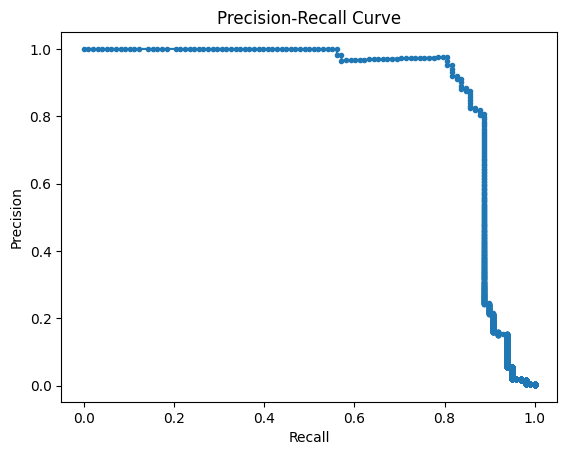

In [13]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_combined_proba)

# Create the plot
fig, ax = plt.subplots()
ax.plot(recall, precision, marker='.')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curve')

# Automatically close the plot after 30 seconds
close_plot_after_delay(fig, 30)

# Show the plot
plt.show()

# Find the optimal threshold based on precision-recall curve

In [14]:
optimal_idx = np.argmax(precision - recall)
optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else thresholds[-1]
print(f"\nOptimal Threshold: {optimal_threshold}")

# Save optimal threshold for reporting or model comparison
with open('model_performance.txt', 'a') as f:
    f.write(f"Optimal Threshold: {optimal_threshold}\n")


Optimal Threshold: 0.8424429208544737


# Make predictions with the optimal threshold

In [15]:
threshold = 0.65
y_pred_combined_threshold = (y_pred_combined_proba >= threshold).astype(int)

print("\nClassification Report for Voting Model:")
print(classification_report(y_test, y_pred_combined_threshold))

print("\nConfusion Matrix for Voting Model:")
print(confusion_matrix(y_test, y_pred_combined_threshold))


Classification Report for Voting Model:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.88      0.85      0.86        98

    accuracy                           1.00     56962
   macro avg       0.94      0.92      0.93     56962
weighted avg       1.00      1.00      1.00     56962


Confusion Matrix for Voting Model:
[[56853    11]
 [   15    83]]


# Extract feature importances from individual models

In [16]:
try:
    feature_importance_rf = rf_model.feature_importances_
    feature_importance_gb = gb_model.feature_importances_

    # Create dataframes for feature importances from both models
    feature_importance_rf_df = pd.DataFrame({'feature': X.columns, 'importance_rf': feature_importance_rf})
    feature_importance_gb_df = pd.DataFrame({'feature': X.columns, 'importance_gb': feature_importance_gb})

    # Merge or compare the feature importances
    feature_importance_combined = feature_importance_rf_df.merge(feature_importance_gb_df, on='feature')
    print("\nCombined Feature Importances (from RandomForest and GradientBoosting):")
    print(feature_importance_combined)

except AttributeError:
    print("Some models do not support feature importances, skipping feature importance extraction.")

Some models do not support feature importances, skipping feature importance extraction.


# Dump Pickle

### To save the model binary "pickle" for later use, uncomment the code below and run the cell

In [17]:
# with open('voting_model.pkl', 'wb') as model_file:
#     pickle.dump(voting_model, model_file)